In [0]:
from keras import backend as K
import scipy.io as sio
from keras import Sequential
from keras.layers.core import Dense, Activation, Dropout,Flatten
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D, BatchNormalization, SimpleRNN, LSTM, Bidirectional
import keras
from keras import optimizers
from google.colab import files
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import os
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import time
from sklearn import svm 
from sklearn import metrics
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score
from IPython.display import Image
import pandas as pd
from keras.utils import np_utils
import pickle
from keras.callbacks import ModelCheckpoint
import sys 
import json
import numpy as np
import random
import re 
from keras import backend as K
import scipy.io as sio
from keras import Sequential
from keras.layers.core import Dense, Activation, Dropout,Flatten

# chequeamos que funcione GPU 
K.tensorflow_backend._get_available_gpus()


Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

Preprocesamiento de texto: <br>
- Se crean listas con todos los contextos y todas las preguntas. 
- Se crean embeddings de 50 dimensiones con GloVe de cada palabra para cada contexto y cada pregunta. 
- Para las respuestas el label a predecir es la ubicación en el contexto donde se puede encontrar la respuesta, es decir START, END. 
- Donde START es el index dentro del contexto donde se puede encontrar la respuesta a la pregunta y END es donde termina. 
- El objetivo es que el modelo aprenda donde encontrar en el contexto la respuesta a las preguntas. 
- Notar que el dataset venia con el index de la letra donde se puede encontrar la respuesta, pero fue modificado para el index de la palabra. 
- Otro aspecto dentro del preprocesamiento es que se utiliza padding para que contextos y preguntas tengan el largo maximo 731 y 60 respectivamente. El resto se lleno con ceros. 


In [0]:
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json 
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json 
#!wget http://nlp.stanford.edu/data/wordvecs/glove.6B.zip
#!unzip glove.6B.zip

# glove dict 50d 
!wget https://www.dropbox.com/s/q6r421os6ike0fw/glovedict_50d.json.zip
!unzip glovedict_50d.json.zip 

# glove dict 
#!wget https://www.dropbox.com/s/z4n4m00fjrdcaoy/glove_dict.json.zip
#!unzip glove_dict.json.zip


--2018-06-04 21:45:44--  https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30288272 (29M) [application/json]
Saving to: ‘train-v1.1.json’

train-v1.1.json     100%[===================>]  28.88M  66.9MB/s    in 0.4s    

2018-06-04 21:45:45 (66.9 MB/s) - ‘train-v1.1.json’ saved [30288272/30288272]

--2018-06-04 21:45:46--  https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json
Resolving rajpurkar.github.io (rajpurkar.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to rajpurkar.github.io (rajpurkar.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4854279 (4.6M) [application/json]
Saving to: ‘dev-v1.1.json’

dev-v1.1.json       

In [0]:
!ls

datalab        glovedict_50d.json      train-v1.1.json
dev-v1.1.json  glovedict_50d.json.zip


# EMBEDDING OBTENTION LSTM 

In [0]:
import json
#with open('glove_dict.json') as f:
 #   glove_dict = json.load(f)
    
with open('glovedict_50d.json') as f:
    glove_dict50 = json.load(f)
     
    

Funciones auxiliares:

In [0]:
import keras
import random
from itertools import chain, repeat, islice

def glove_embeddings(data):
    result = []
    for word in data.split():
        if word in glove_dict:
          result.append(glove_dict[word])
        else:
          result.append([random.random() for x in range(300)])
    return result

#recordar definir dict de 50 como glove_dict50
def glove_embeddings50(data):
    result = []
    for word in data.split():
        if word in glove_dict50:
          result.append(glove_dict50[word])
        else:
          result.append([random.random() for x in range(50)])
    return result
  

def context_obtention(filename):
    texts = []
    with open(filename, "r") as fh:
        source = json.load(fh)
        for article in source["data"]:
            for para in article["paragraphs"]:
                context = para["context"].replace("''", '" ').replace("``", '" ')
                texts.append(context.lower())
    return texts

def question_obtention(filename):
    questions = []
    with open('train-v1.1.json') as file:
        source = json.load(file)
        for article in source['data']:
            for q in article['paragraphs']:
                for question in q['qas']:
                    questions.append(question['question'])
    return questions

def answers_index(filename):
    answers_indx = {}
    indx_answers = {}
    list_indx = []

    count = 0 

    with open('train-v1.1.json') as file:
        source = json.load(file)
        for article in source['data']:
            for q in article['paragraphs']:
                for question in q['qas']:
                    answers_indx[count] = question['answers'][0]['text']
                    indx_answers[question['answers'][0]['text']] = count
                    list_indx.append(count)
                    count+=1
                    
    return answers_indx, indx_answers, list_indx

def context_question_answer(filename):
  result = []
  with open('train-v1.1.json') as file:
        source = json.load(file)
        for article in source['data']:
            for q in article['paragraphs']:
              for question in q['qas']:
                context = q["context"].replace("''", '" ').replace("``", '" ').lower() 
                result.append([context, question['question'],question['answers'][0]['text']] )
  return result

def pad_infinite(iterable, padding=None):
   return chain(iterable, repeat(padding))

def pad(iterable, size, padding=None):
   return islice(pad_infinite(iterable, padding), size)

def indexword2letter(context, letter_index):
    result = 0
    cont = 0
    letras = enumerate(context)
    
    for i,j in letras:
        if j == ' ':
            cont +=1
            
        if i == letter_index and cont>0:
          result = cont
          
        if i == letter_index and cont ==0:
          result = cont
          
    return result


In [0]:
contexts = context_obtention("train-v1.1.json")
print('total contextos: {}'.format(len(contexts)))

questions = question_obtention("train-v1.1.json")
print('total preguntas: {}'.format(len(questions)))

# index para cada pregunta para pasarlo a numero en la clasificacion 
answers_indx, indx_answer, list_indx = answers_index("train-v1.1.json")
print('total respuestas: {}'.format(len(answers_indx)))

total contextos: 18896
total preguntas: 87599
total respuestas: 87599


In [0]:
import time
filename = 'train-v1.1.json'

total = 0

data = list()

cont = ""
preg = ""
resp1 = ""
resp2 = ""

train_set = list()
train_set_label = list()

train_set_context = list()
train_set_question = list()

contador = 0;

with open(filename, "r") as fh:
    source = json.load(fh)
    for article in source["data"]:
        for para in article["paragraphs"]:
            
            context_text = para["context"].replace("''", '" ').replace("``", '" ').replace(')','').replace('(','')
            cont = np.asarray(glove_embeddings50(context_text))
            
            for qa in para["qas"]:
                total += 1
                preg = np.asarray(glove_embeddings50(qa["question"].replace("''", '" ').replace("``", '" ')))    
                y1s, y2s = [], []
                answer_texts = []
                for answer in qa["answers"]:
                  answer_text = answer["text"]
                  answer_start = indexword2letter(para['context'], answer['answer_start'])  
                  answer_end = answer_start + len(answer_text)
                  y1s = answer_start
                  y2s = answer_end
             
                train_set_context.append(np.asarray(cont))
                train_set_question.append(np.asarray(preg))
                train_set_label.append(y1s)
      
      
train_set_context = np.asarray(train_set_context)
train_set_question = np.asarray(train_set_question)
train_set_label = np.asarray(train_set_label)

In [0]:
# obtenemos tamano maximo de palabras contexto 
filename = 'train-v1.1.json'

tamano_de_palabras_contextos = []

with open(filename, "r") as fh:
  source = json.load(fh) 
  for article in source["data"]:
    for para in article["paragraphs"]:
      tamano_de_palabras_contextos.append(len(para["context"].replace("''", '" ').replace("``", '" ').replace("?"," ?").replace(".", " .").replace(",", " ,").split()))
max_tamano_de_palabras_contextos = max(tamano_de_palabras_contextos)


# obtenemos tamano maximo de palabras preguntas 
tamano_de_palabras_preguntas = []

with open(filename, "r") as fh:
  source = json.load(fh) 
  for article in source["data"]:
    for para in article["paragraphs"]:
      for qa in para["qas"]:
        tamano_de_palabras_preguntas.append(len(qa["question"].replace("''", '" ').replace("``", '" ').replace("?"," ?").replace(".", " .").replace(",", " ,").split()))
max_tamano_de_palabras_preguntas = max(tamano_de_palabras_preguntas)


# obtenemos tamano maximo de palabras respuestas 
tamano_de_palabras_respuestas = []

print("Contexto maximo de palabras:",max_tamano_de_palabras_contextos)
print("Preguntas maximo de palabras:",max_tamano_de_palabras_preguntas)


Contexto maximo de palabras: 731
Preguntas maximo de palabras: 60
Respuestas maximo de palabras: 60


In [0]:
from keras.preprocessing.sequence import pad_sequences,TimeseriesGenerator
from keras.utils import to_categorical
import itertools

sequences_context = train_set_context
sequences_questions = train_set_question

def generator(data1, data2, labels, batch_size):
  contador_generator=0
  samples_per_epoch = data1.shape[0] #data1 y 2 son del mismo tamaño
  number_of_batches = samples_per_epoch/batch_size
  labels = to_categorical(labels)
  
  for contador_generator in itertools.cycle(range(0,int(87599/batch_size))):
    batch1 = pad_sequences(data1[batch_size*contador_generator:batch_size*(contador_generator+1)], maxlen=max_tamano_de_palabras_contextos, dtype='float', padding='post', truncating='post', value=np.zeros(50))
    batch2 = pad_sequences(data2[batch_size*contador_generator:batch_size*(contador_generator+1)], maxlen=max_tamano_de_palabras_preguntas, dtype='float', padding='post', truncating='post', value=np.zeros(50))
    batch_label = labels[batch_size*contador_generator:batch_size*(contador_generator+1)]
    
    #contador_generator = contador_generator + 1
    yield [batch1,batch2],batch_label 

    #restart counter to yeild data in the next epoch as well
    if contador_generator >= number_of_batches:
        contador_generator = 0


    
aas = generator(train_set_context,train_set_question, train_set_label, 32)


def testmodel(epoch, logs):
    x, y = next(aas)
    predout = model.predict(x, batch_size=32)
    print('Target: {} Prediccion: {}'.format(np.argmax(y), np.argmax(predout)))

In [0]:
from keras.models import Sequential
from keras.layers import Merge, Activation, Dense, Concatenate, InputLayer, CuDNNLSTM
from keras.layers.recurrent import LSTM
from keras import optimizers

from keras.layers.embeddings import Embedding
from keras.layers import Masking

batch_size = 800
timesteps_contexto = max_tamano_de_palabras_contextos
timesteps_pregunta = max_tamano_de_palabras_preguntas
input_dim = 50 #por glove dict 50

optimizer = optimizers.Adam(lr=0.001)

left = Sequential()
left.add(CuDNNLSTM(input_shape=(max_tamano_de_palabras_contextos, input_dim),units=50)) #batch_input_shape=(1,1,4096) #(batch size,timesteps,feature shape)
left.add(Activation('relu'))

right = Sequential()
right.add(CuDNNLSTM(input_shape=(max_tamano_de_palabras_preguntas, input_dim), units=50))
left.add(Activation('relu'))

model = Sequential()
model.add(Merge([left, right],mode='concat'))
model.add(Activation('relu'))
 
model.add(Dense(497))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',optimizer= optimizer, metrics=['accuracy'])

# Callback para mostrar predicciones 
testmodelcb = keras.callbacks.LambdaCallback(on_epoch_end=testmodel)

step_per_epocas = len(answers_indx)/batch_size

model.fit_generator(aas, steps_per_epoch=step_per_epocas, epochs = 100, callbacks=[testmodelcb])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


Epoch 1/100
110/109 [==============================] - 12s 107ms/step - loss: 5.4356 - acc: 0.0227
Target: 13 Prediccion: 497
Epoch 2/100
110/109 [==============================] - 11s 99ms/step - loss: 4.9448 - acc: 0.0270
Target: 70 Prediccion: 497
Epoch 3/100
110/109 [==============================] - 11s 98ms/step - loss: 4.9688 - acc: 0.0202
Target: 21 Prediccion: 994
Epoch 4/100
 50/109 [============>.................] - ETA: 5s - loss: 5.0341 - acc: 0.0081

110/109 [==============================] - 11s 97ms/step - loss: 5.0285 - acc: 0.0142
Target: 61 Prediccion: 5964
Epoch 5/100
110/109 [==============================] - 11s 97ms/step - loss: 4.9345 - acc: 0.0216
Target: 56 Prediccion: 8449
Epoch 6/100
110/109 [==============================] - 11s 98ms/step - loss: 4.9886 - acc: 0.0205
Target: 12 Prediccion: 13916
Epoch 7/100
 66/109 [=================>............] - ETA: 4s - loss: 4.9314 - acc: 0.0317

110/109 [==============================] - 11s 97ms/step - loss: 4.9476 - acc: 0.0267
Target: 49 Prediccion: 11928
Epoch 8/100
110/109 [==============================] - 11s 98ms/step - loss: 4.9929 - acc: 0.0134
Target: 39 Prediccion: 10438
Epoch 9/100
 77/109 [====================>.........] - ETA: 3s - loss: 4.9481 - acc: 0.0264

KeyboardInterrupt: ignored

In [0]:
!rm LSTM_P3.png

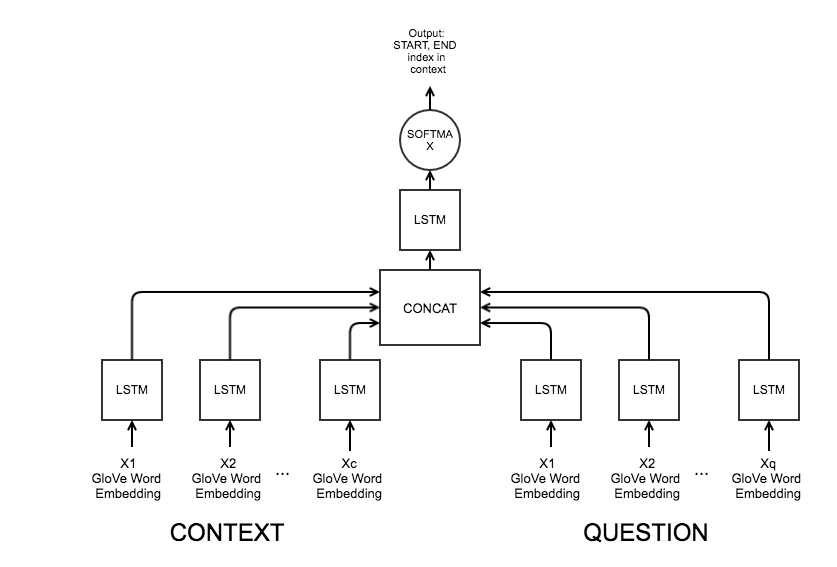

In [0]:
#from IPython.display import Image
#files.upload()
Image('LSTM_P3_.png')

- Le entregamos los embeddings obtenidos con GloVe de los contextos y las preguntas a dos modelos LSTM respectivamente.
- Le hacemos padding con vectores de 0, 50 dimensiones a ambos para que queden todos los mismo largo. 
- Concatenamos los modelos LSTM de contexto y de preguntas. 
- Metemos ese input a una LSTM para generar las predicciones del index dentro del contexto donde empieza (START) y donde termina (END) la respuesta a la pregunta. (como se menciono antes en el procesamiento de texto)

### Actividad 9: Validacion

In [0]:
import time
filename_test = 'dev-v1.1.json'

total = 0

data = list()

cont = ""
preg = ""
resp1 = ""
resp2 = ""

test_set = list()
test_set_label = list()

test_set_context = list()
test_set_question = list()

contador = 0;

with open(filename_test, "r") as fh:
    source = json.load(fh)
    for article in source["data"]:
        for para in article["paragraphs"]:
            cont = np.asarray(glove_embeddings50(para["context"].replace("''", '" ').replace("``", '" ')))
            
            for qa in para["qas"]:
                total += 1
                preg = np.asarray(glove_embeddings50(qa["question"].replace("''", '" ').replace("``", '" ')))    
                y1s, y2s = [], []
                answer_texts = []
                for answer in qa["answers"]:
                    answer_text = answer["text"]
                    answer_start = answer['answer_start']
                    answer_end = answer_start + len(answer_text)
                    y1s = answer_start
                    y2s = answer_end

                test_set_context.append(np.asarray(cont))
                test_set_question.append(np.asarray(preg))
                test_set_label.append(y1s)
      
      
test_set_context = np.asarray(test_set_context)
test_set_question = np.asarray(test_set_question)
test_set_label = np.asarray(test_set_label)

Funciones de validacion:

In [0]:
from collections import Counter
import string
import re
import argparse
import json
import sys

def f1_score(prediction, ground_truth):
    common = Counter(prediction) & Counter(ground_truth)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction)
    recall = 1.0 * num_same / len(ground_truth)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def exact_match_score(prediction, ground_truth):
    return prediction == ground_truth


In [0]:
filename= 'dev-v1.1.json'

context_test = test_set_context
question_test = test_set_question
label_test = test_set_label

prediction_start = []
target_start = []

prediction_end = []
target_end = []

exact_matches_start = 0
exact_matches_end = 0

test_sample = len(label_test)

for x in range(test_sample):
  x, y = next(aas)
  predout1 = model.predict(x[0], batch_size=251)
  prediction_start.append(np.argmax(predout1))
  target_start.append(np.argmax(y[0]))
  
  predout2 = model.predict(x[1], batch_size=251)
  prediction_end.append(np.argmax(predout2))
  target_end.append(np.argmax(y[1]))
  
  
  if np.argmax(y) == np.argmax(predout):
    exact_matches_start += 1
  
  if np.argmax(y) == np.argmax(predout):
    exact_matches_end += 1
  
  

In [0]:
print('f1 score: {}'.format(f1_score(prediction, target)))
print('exact_match score: {}'.format(exact_matches/test_sample))